# CIFAR-100 분류 - LeNet-5 CNN 모델

이 노트북에서는 LeNet-5 아키텍처를 기반으로 CIFAR-100 데이터셋을 분류하는 CNN 모델을 구현합니다.

## LeNet-5 아키텍처 개요
![](./lenet-5.png)

CIFAR-100은 100개 클래스의 32x32 컬러 이미지 데이터셋입니다.


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 맥북 한글 폰트 설정
import platform
from matplotlib import font_manager

def setup_korean_font():
    """맥북에서 사용 가능한 한글 폰트를 찾아서 설정"""
    system = platform.system()
    print(f"🖥️ 운영체제: {system}")
    
    if system == 'Darwin':  # macOS
        # 맥북에서 사용 가능한 한글 폰트 목록 (우선순위 순)
        korean_fonts = [
            'AppleSDGothicNeo-Regular',
            'AppleGothic', 
            'Nanum Gothic',
            'NanumGothic',
            'Malgun Gothic',
            'Arial Unicode MS'
        ]
        
        # 시스템에 설치된 폰트 목록 가져오기
        available_fonts = [f.name for f in font_manager.fontManager.ttflist]
        
        # 사용 가능한 한글 폰트 찾기
        selected_font = None
        for font in korean_fonts:
            if font in available_fonts:
                selected_font = font
                break
        
        if selected_font:
            plt.rcParams['font.family'] = selected_font
            print(f"✅ 한글 폰트 설정 완료: {selected_font}")
        else:
            # 대안: 유니코드 지원 폰트 사용
            plt.rcParams['font.family'] = 'Arial Unicode MS'
            print("⚠️ 기본 한글 폰트를 찾을 수 없어 Arial Unicode MS 사용")
            
    else:
        plt.rcParams['font.family'] = 'Malgun Gothic'
        print(f"✅ 한글 폰트 설정: Malgun Gothic")
    
    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False
    print("✅ 마이너스 기호 깨짐 방지 설정 완료")

# 한글 폰트 설정 실행
setup_korean_font()


🖥️ 운영체제: Darwin
✅ 한글 폰트 설정 완료: AppleGothic
✅ 마이너스 기호 깨짐 방지 설정 완료


In [2]:
# 필요한 라이브러리 import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"TensorFlow 버전: {tf.__version__}")
print(f"GPU 사용 가능: {tf.config.list_physical_devices('GPU')}")

# 한글 폰트 설정 (matplotlib)
plt.rcParams['font.family'] = 'DejaVu Sans'


TensorFlow 버전: 2.16.2
GPU 사용 가능: []


## 데이터 로드

In [7]:
# CIFAR-100 클래스 이름 정의
cifar100_class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

print(f"CIFAR-100 클래스 개수: {len(cifar100_class_names)}")
print("첫 10개 클래스:", cifar100_class_names[:10])


CIFAR-100 클래스 개수: 100
첫 10개 클래스: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']


In [8]:
# CIFAR-100 데이터셋 로드 및 전처리
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"훈련 데이터 형태: {x_train.shape}")
print(f"훈련 레이블 형태: {y_train.shape}")
print(f"테스트 데이터 형태: {x_test.shape}")
print(f"테스트 레이블 형태: {y_test.shape}")

# 클래스 수 확인
num_classes = 100
print(f"클래스 수: {num_classes}")

# 픽셀 값을 0-1 범위로 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 레이블을 원-핫 인코딩
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"정규화 후 훈련 데이터 범위: {x_train.min():.2f} ~ {x_train.max():.2f}")
print(f"원-핫 인코딩 후 레이블 형태: {y_train.shape}")


훈련 데이터 형태: (50000, 32, 32, 3)
훈련 레이블 형태: (50000, 1)
테스트 데이터 형태: (10000, 32, 32, 3)
테스트 레이블 형태: (10000, 1)
클래스 수: 100
정규화 후 훈련 데이터 범위: 0.00 ~ 1.00
원-핫 인코딩 후 레이블 형태: (50000, 100)


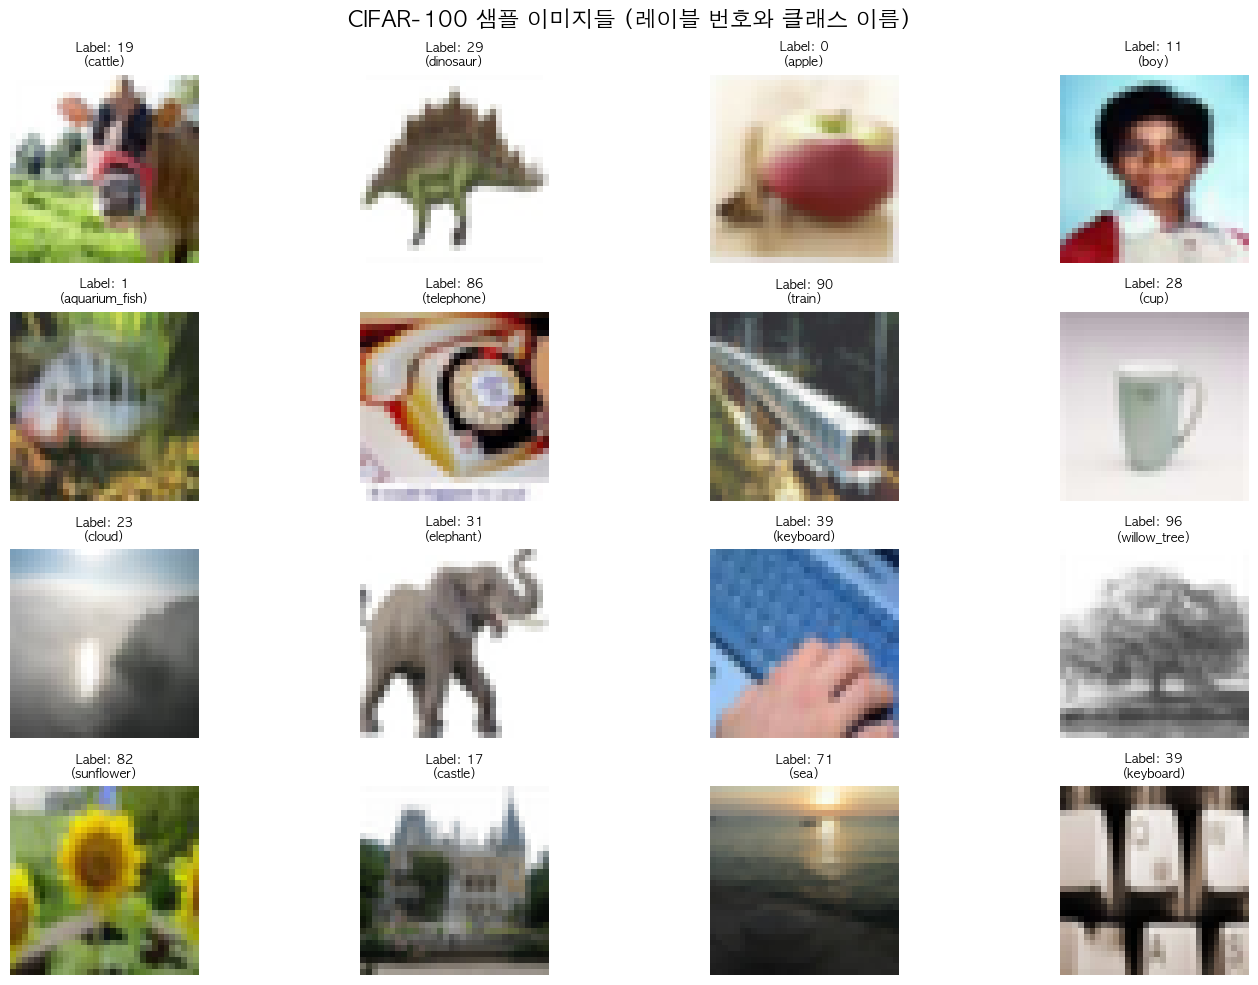

In [10]:
# 개선된 샘플 이미지 시각화 (레이블 번호와 클래스 이름 포함)
plt.figure(figsize=(15, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i])
    label_idx = np.argmax(y_train[i])
    class_name = cifar100_class_names[label_idx]
    plt.title(f'Label: {label_idx}\n({class_name})', fontsize=9)
    plt.axis('off')

plt.suptitle('CIFAR-100 샘플 이미지들 (레이블 번호와 클래스 이름)', fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
# LeNet-5 기반 CNN 모델 구현 (CIFAR-100용으로 수정)
def create_lenet5_cifar100():
    model = models.Sequential([
        # 첫 번째 Convolution Layer
        # CIFAR-100은 32x32x3 입력이므로 패딩을 추가하여 LeNet-5와 유사하게 만듦
        layers.Conv2D(6, (5, 5), activation='tanh', input_shape=(32, 32, 3), padding='same'),
        layers.AveragePooling2D((2, 2)),
        
        # 두 번째 Convolution Layer  
        layers.Conv2D(16, (5, 5), activation='tanh'),
        layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        layers.Flatten(),
        
        # Fully Connected Layers
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        
        # Output layer (CIFAR-100은 100개 클래스)
        layers.Dense(100, activation='softmax')
    ])
    
    return model

# 모델 생성
model = create_lenet5_cifar100()

# 모델 구조 출력
model.summary()


/Users/aaron/Github/Kmong/Aaron/hg-mldl2/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 6, 6, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        69,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │         8,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,776 (354.59 KB)

 Trainable params: 90,776 (354.59 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 모델 아키텍처 시각화
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=150)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [13]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("모델 컴파일 완료!")
print(f"옵티마이저: Adam")
print(f"손실 함수: Categorical Crossentropy")
print(f"평가 지표: Accuracy")


모델 컴파일 완료!
옵티마이저: Adam
손실 함수: Categorical Crossentropy
평가 지표: Accuracy


In [14]:
# 콜백 함수 설정
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 조기 종료
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 학습률 감소
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# 모델 체크포인트
checkpoint = ModelCheckpoint(
    'best_lenet5_cifar100_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]


In [15]:
# 모델 학습
print("모델 학습을 시작합니다...")
print("CIFAR-100은 복잡한 데이터셋이므로 학습에 시간이 오래 걸릴 수 있습니다.")

history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("학습 완료!")


모델 학습을 시작합니다...
CIFAR-100은 복잡한 데이터셋이므로 학습에 시간이 오래 걸릴 수 있습니다.
Epoch 1/50
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0661 - loss: 4.2359
Epoch 1: val_accuracy improved from -inf to 0.14340, saving model to best_lenet5_cifar100_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.0662 - loss: 4.2347 - val_accuracy: 0.1434 - val_loss: 3.7340 - learning_rate: 0.0010
Epoch 2/50
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1595 - loss: 3.6403
Epoch 2: val_accuracy improved from 0.14340 to 0.17920, saving model to best_lenet5_cifar100_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.1595 - loss: 3.6400 - val_accuracy: 0.1792 - val_loss: 3.5318 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1912 - loss: 3.4461
Epoch 3: val_accuracy improved from 0.17920 to 0.19890, saving model to best_lenet5_cifar100_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.1913 - loss: 3.4461 - v

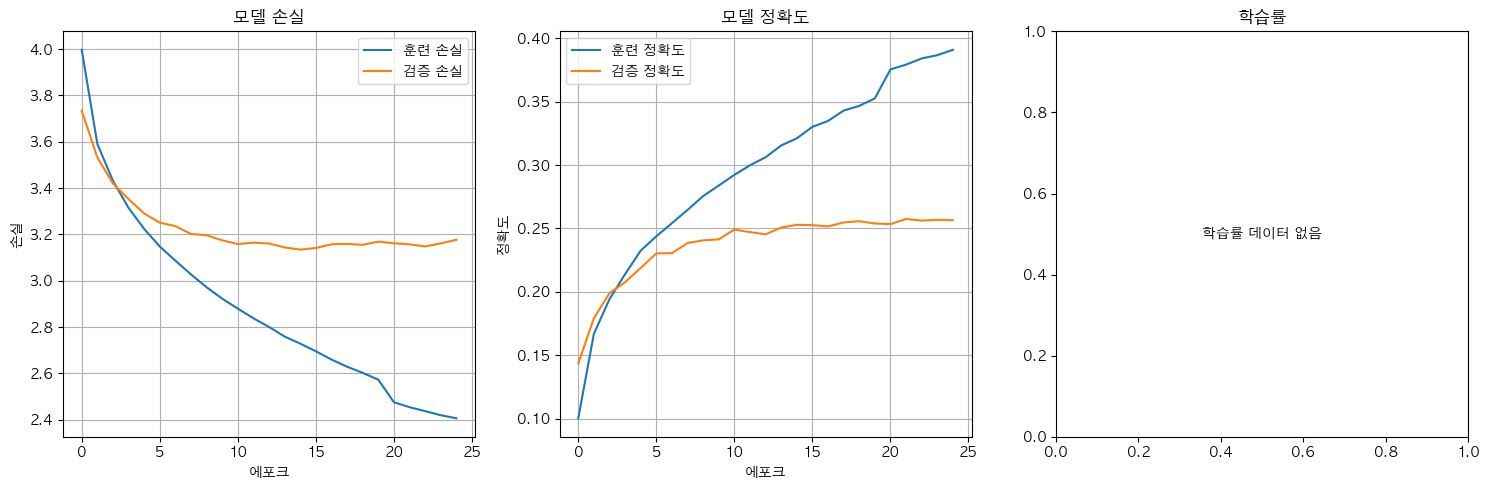

In [16]:
# 학습 과정 시각화
plt.figure(figsize=(15, 5))

# 손실 함수 그래프
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.title('모델 손실')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='훈련 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.title('모델 정확도')
plt.xlabel('에포크')
plt.ylabel('정확도')
plt.legend()
plt.grid(True)

# 학습률 그래프 (있는 경우)
plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'])
    plt.title('학습률 변화')
    plt.xlabel('에포크')
    plt.ylabel('학습률')
    plt.yscale('log')
    plt.grid(True)
else:
    plt.text(0.5, 0.5, '학습률 데이터 없음', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('학습률')

plt.tight_layout()
plt.show()


## 커널 필터 시각화